# import

In [1]:
import os
import time
import exrex
import random
import pickle
import numpy as np
from numpy.lib.stride_tricks import as_strided
import pandas as pd
from math import ceil
from faker import Faker
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from scipy.interpolate import interp1d
from scipy.stats import kstest, ks_2samp, chi2_contingency, wasserstein_distance, norm
import tensorflow as tf
from tensorflow.compat.v1.logging import set_verbosity, ERROR
from tensorflow.keras import layers, models, optimizers, losses, backend, constraints, initializers
from sdv.metadata import MultiTableMetadata
from rdt import HyperTransformer
import rdt.transformers as rt
from tqdm import tqdm

In [2]:
fake = Faker('en-NZ')

In [3]:
set_verbosity(ERROR)

In [4]:
tf.random.set_seed(123)

In [5]:
tf.__version__

'2.6.0'

# load data

Load data into dictionary of dataframes.

In [6]:
def load_data_collection(dir_path):
    gtfs_files = [f for f in os.listdir(dir_path) if f.endswith('.csv') or f.endswith('.txt')]
    data_collection = {}
    for f in gtfs_files:
        f_path = os.path.join(dir_path, f)
        data = pd.read_csv(f_path)
        if data.shape[0] > 1:
            data_collection[f.split(".")[0]] = data
    return data_collection

In [7]:
real_data_collection = load_data_collection("gtfs")

In [8]:
del real_data_collection['shapes']

# Setup SDV Metadata (i.e. Schema)

Follow SDV Multi-Table API: https://docs.sdv.dev/sdv/multi-table-data/data-preparation/multi-table-metadata-api

## (Optional) Adjust Daylight-Savings Delta-Time to Conventional DateTime

In [9]:
def adjust_time(df, datetime_cols):
    """
    Adjust daylight-savings delta-time columns to conventional datetime columns
    
    Args:
        df, (dataframe):
            The dataframe to be adjusted.
        datetime_cols, (list):
            List of column names in (str) specifying the delta-time columns
        
    Returns:
        df, (dataframe):
            The adjusted dataframe
    """
    for col in datetime_cols:
        df[col] = pd.to_timedelta(df[col])
        df[col] = df[col] % pd.Timedelta(days=1)
        df[col] = df[col].astype(str).str.split().str[-1]
    return df

In [10]:
sdv_metadata = MultiTableMetadata()

In [11]:
columns_to_remove = ['agency_name','agency_fare_url', 'agency_email']
real_data_collection['agency'].drop(columns_to_remove, axis=1, inplace=True)

In [12]:
sdv_metadata.detect_table_from_dataframe(table_name='agency', data=real_data_collection['agency'])
sdv_metadata.update_column(table_name='agency',column_name='agency_id',sdtype='id',regex_format='[A-Z]{2,5}')
sdv_metadata.update_column(table_name='agency',column_name='agency_url',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_timezone',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_lang',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_phone',sdtype='categorical')
sdv_metadata.set_primary_key(table_name='agency',column_name='agency_id')

In [13]:
sdv_metadata.detect_table_from_dataframe(table_name='calendar',data=real_data_collection['calendar'])
sdv_metadata.update_column(table_name='calendar',column_name='service_id',sdtype='id',regex_format='[a-zA-Z]{3,5}-\d{1,2}')
sdv_metadata.update_column(table_name='calendar',column_name='monday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='tuesday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='wednesday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='thursday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='friday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='saturday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='sunday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='start_date',sdtype='datetime',datetime_format='%Y%m%d')
sdv_metadata.update_column(table_name='calendar',column_name='end_date',sdtype='datetime',datetime_format='%Y%m%d')
sdv_metadata.set_primary_key(table_name='calendar',column_name='service_id')

In [14]:
sdv_metadata.detect_table_from_dataframe(table_name='calendar_dates',data=real_data_collection['calendar_dates'])
sdv_metadata.update_column(table_name='calendar_dates',column_name='service_id',sdtype='id',regex_format='[a-zA-Z]{3,5}-\d{1,2}')
sdv_metadata.update_column(table_name='calendar_dates',column_name='date',sdtype='datetime',datetime_format='%Y%m%d')
sdv_metadata.update_column(table_name='calendar_dates',column_name='exception_type',sdtype='categorical')

In [15]:
columns_to_remove = ['route_short_name','route_long_name','route_desc', 'route_url','route_sort_order']
real_data_collection['routes'].drop(columns_to_remove, axis=1, inplace=True)
real_data_collection['routes']['route_color'] = real_data_collection['routes']['route_color'].fillna('NA')
real_data_collection['routes']['route_text_color'] = real_data_collection['routes']['route_text_color'].fillna('NA')

In [16]:
sdv_metadata.detect_table_from_dataframe(table_name='routes',data=real_data_collection['routes'])
sdv_metadata.update_column(table_name='routes',column_name='route_id',sdtype='id',regex_format='[A-Z]{2,6}-\d{3}')
sdv_metadata.update_column(table_name='routes',column_name='agency_id',sdtype='id',regex_format='[A-Z]{2,5}')
sdv_metadata.update_column(table_name='routes',column_name='route_type',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_color',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_text_color',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='contract_id',sdtype='id',regex_format='([A-Z]{1,5}|\d{1,5})')
sdv_metadata.set_primary_key(table_name='routes',column_name='route_id')

In [17]:
columns_to_remove = ['stop_code','stop_name','stop_desc', 'zone_id','stop_url','stop_timezone']
real_data_collection['stops'].drop(columns_to_remove, axis=1, inplace=True)
real_data_collection['stops']['parent_station'] = real_data_collection['stops']['parent_station'].fillna('NA')
real_data_collection['stops']['platform_code'] = real_data_collection['stops']['platform_code'].fillna('NA')

In [18]:
sdv_metadata.detect_table_from_dataframe(table_name='stops',data=real_data_collection['stops'])
sdv_metadata.update_column(table_name='stops',column_name='stop_id',sdtype='id',regex_format='\d{4,5}-[a-z\d]{8}')
sdv_metadata.update_column(table_name='stops',column_name='stop_lat',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stops',column_name='stop_lon',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stops',column_name='location_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='parent_station',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='platform_code',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='wheelchair_boarding',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='start_date',sdtype='datetime',datetime_format='%Y%m%d')
sdv_metadata.update_column(table_name='stops',column_name='end_date',sdtype='datetime',datetime_format='%Y%m%d')
sdv_metadata.set_primary_key(table_name='stops',column_name='stop_id')

In [19]:
columns_to_remove = ['stop_headsign']
real_data_collection['stop_times'].drop(columns_to_remove, axis=1, inplace=True)
real_data_collection['stop_times'] = adjust_time(real_data_collection['stop_times'], ['arrival_time','departure_time'])

In [20]:
sdv_metadata.detect_table_from_dataframe(table_name='stop_times',data=real_data_collection['stop_times'])
sdv_metadata.update_column(table_name='stop_times',column_name='trip_id',sdtype='id',regex_format='\d{1,5}-\d{1,7}-\d{1,5}-2-[a-z\d]{1,8}(-[a-z\d]{1,8})?')
sdv_metadata.update_column(table_name='stop_times',column_name='arrival_time',sdtype='datetime',datetime_format='%H:%M:%S')
sdv_metadata.update_column(table_name='stop_times',column_name='departure_time',sdtype='datetime',datetime_format='%H:%M:%S')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_id',sdtype='id',regex_format='\d{4,5}-[a-z\d]{8}')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_sequence',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stop_times',column_name='pickup_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='drop_off_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='shape_dist_traveled',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stop_times',column_name='timepoint',sdtype='numerical',computer_representation='Int32')

In [21]:
columns_to_remove = ['trip_headsign','trip_short_name', 'block_id']
real_data_collection['trips'].drop(columns_to_remove, axis=1, inplace=True)

In [22]:
sdv_metadata.detect_table_from_dataframe(table_name='trips',data=real_data_collection['trips'])
sdv_metadata.update_column(table_name='trips',column_name='route_id',sdtype='id',regex_format='[A-Z]{2,6}-\d{3}')
sdv_metadata.update_column(table_name='trips',column_name='service_id',sdtype='id',regex_format='[a-zA-Z]{3,5}-\d{1,2}')
sdv_metadata.update_column(table_name='trips',column_name='trip_id',sdtype='id',regex_format='\d{1,5}-\d{1,7}-\d{1,5}-2-[a-z\d]{1,8}(-[a-z\d]{1,8})?')
sdv_metadata.update_column(table_name='trips',column_name='direction_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='shape_id',sdtype='id',regex_format='\d{1,4}-\d{5,6}-[a-z\d]{8}')
sdv_metadata.update_column(table_name='trips',column_name='wheelchair_accessible',sdtype='categorical')
sdv_metadata.update_column(table_name='trips',column_name='bikes_allowed',sdtype='categorical')
sdv_metadata.set_primary_key(table_name='trips',column_name='trip_id')

In [23]:
sdv_metadata.add_relationship(
    parent_table_name='agency',
    child_table_name='routes',
    parent_primary_key='agency_id',
    child_foreign_key='agency_id'
)

sdv_metadata.add_relationship(
    parent_table_name='calendar',
    child_table_name='calendar_dates',
    parent_primary_key='service_id',
    child_foreign_key='service_id'
)

sdv_metadata.add_relationship(
    parent_table_name='calendar',
    child_table_name='trips',
    parent_primary_key='service_id',
    child_foreign_key='service_id'
)

sdv_metadata.add_relationship(
    parent_table_name='routes',
    child_table_name='trips',
    parent_primary_key='route_id',
    child_foreign_key='route_id'
)

sdv_metadata.add_relationship(
    parent_table_name='stops',
    child_table_name='stop_times',
    parent_primary_key='stop_id',
    child_foreign_key='stop_id'
)

sdv_metadata.add_relationship(
    parent_table_name='trips',
    child_table_name='stop_times',
    parent_primary_key='trip_id',
    child_foreign_key='trip_id'
)

In [24]:
sdv_metadata.validate()

## (Optional) View Inter-Table Structure

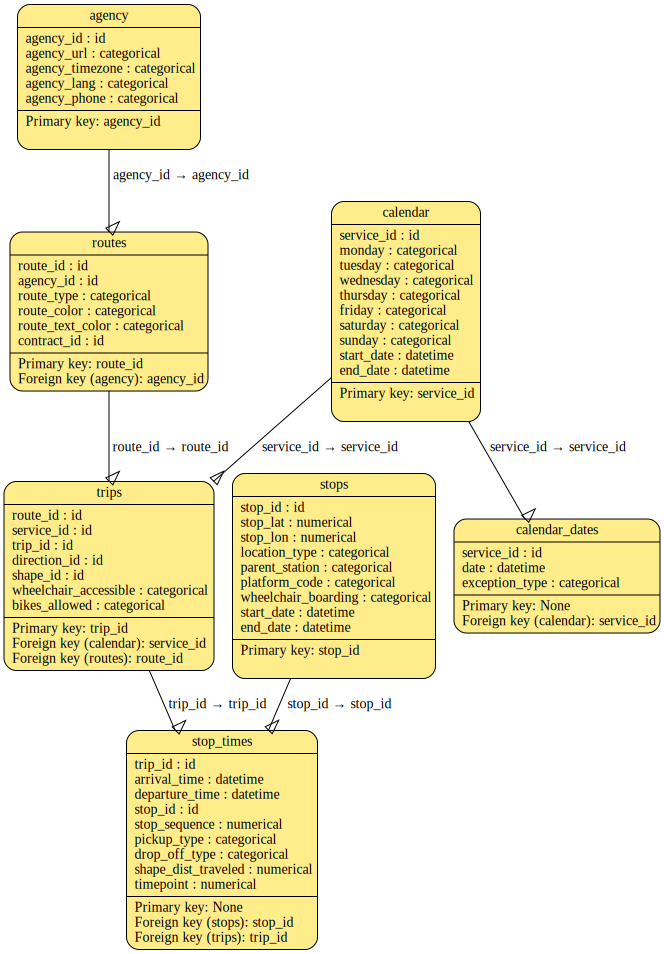

In [25]:
sdv_metadata.visualize(output_filepath='visualization/gtfs.jpeg')

# Preprocessing

In [26]:
training_start_time = time.time()

## Create Modelling Metadata

Setup dictionary for identifying the primary key, parent(s), child(ren) and foreign key(s) of each table.

In [27]:
def sdvmetadata_to_modelmetadata(sdv_metadata):
    """
    create a dictionary of modelling info from a sdv metadata object.
    
    Args:
        sdv_metadata, (dict):
            The dictionary form of a valid sdv.metadata.multi_table.MultiTableMetadata object.
        
    Returns:
        modelling_metadata, (dict):
            A nested dictionary storing the modelling information.
            An example can be:
                {
                    "df1":{
                        "primary_key": "col1",
                        "parent": {"df2":"col2", ...},
                        "child": {"df3":"col3", ...},
                        "is_sequential": False,
                        "sort_order":None,
                        "step_index":None
                    },
                    "df2":{
                        ...
                    },
                    ...
                }
    """
    modelling_metadata = {}
    for df_name, content in sdv_metadata["tables"].items():
        modelling_metadata[df_name] = {
            "primary_key": content.get("primary_key"),
            "parent": {},
            "child": {},
            "is_sequential": False,
            "sort_order":None,
            "step_index":None
        }
    for relationship in sdv_metadata["relationships"]:
        parent_table = relationship["parent_table_name"]
        child_table = relationship["child_table_name"]
        foreign_key = relationship["child_foreign_key"]
        modelling_metadata[child_table]["parent"][parent_table] = foreign_key
        modelling_metadata[parent_table]["child"][child_table] = foreign_key
    return modelling_metadata

In [28]:
modelling_metadata = sdvmetadata_to_modelmetadata(sdv_metadata.to_dict())

In [29]:
modelling_metadata['calendar_dates']['is_sequential']=True
modelling_metadata['calendar_dates']['sort_order']=['service_id','date']
modelling_metadata['calendar_dates']['step_index']=['date']
modelling_metadata['stop_times']['is_sequential']=True
modelling_metadata['stop_times']['sort_order']=['trip_id','stop_sequence']
modelling_metadata['stop_times']['step_index']=['stop_sequence']

## Fit RDT Transformers and Formatters

Use tools from RDT package to convert data to solely numeric and back-transforming to the original format.

In [30]:
def create_formatter_collection(data_collection):
    """
    Create and fit RDT transformers for the input dictionary of dataframes.
    
    Args:
        data_collection, (dict):
            A dictionary of dateframe.
        
    Returns:
        formatter_collection, (dict):
            A dictionary of fitted RDT transformers of each dataframe in the input dictionary.
    """
    formatter_collection = {}
    for df_name, df in data_collection.items():
        ht = HyperTransformer()
        ht.detect_initial_config(df)
        ht.update_transformers_by_sdtype(
            sdtype='categorical',
            transformer_name='LabelEncoder'
        )
        ht.fit(df)
        formatter_collection[df_name] = ht
    return formatter_collection

In [31]:
%%time
formatter_collection = create_formatter_collection(real_data_collection)

CPU times: total: 3.64 s
Wall time: 3.62 s


### (Optional) Adjust Incorrectly Detected Column Types from RDT's Auto-Detection

In [32]:
formatter_collection['stop_times'].get_config()

{
    "sdtypes": {
        "trip_id": "categorical",
        "arrival_time": "categorical",
        "departure_time": "categorical",
        "stop_id": "categorical",
        "stop_sequence": "numerical",
        "pickup_type": "numerical",
        "drop_off_type": "numerical",
        "shape_dist_traveled": "numerical",
        "timepoint": "numerical"
    },
    "transformers": {
        "trip_id": LabelEncoder(),
        "arrival_time": LabelEncoder(),
        "departure_time": LabelEncoder(),
        "stop_id": LabelEncoder(),
        "stop_sequence": FloatFormatter(),
        "pickup_type": FloatFormatter(),
        "drop_off_type": FloatFormatter(),
        "shape_dist_traveled": FloatFormatter(),
        "timepoint": FloatFormatter()
    }
}

In [33]:
formatter_collection['stop_times'].update_sdtypes(column_name_to_sdtype={
    'pickup_type':'categorical',
    'drop_off_type':'categorical'
})
formatter_collection['stop_times'].update_transformers_by_sdtype(
    sdtype='categorical',
    transformer_name='LabelEncoder'
)
formatter_collection['stop_times'].fit(real_data_collection['stop_times'])

C:\programs\conda\envs\tfgpu\lib\site-packages\rdt\hyper_transformer.py:390: UserWarning: For this change to take effect, please refit your data using 'fit' or 'fit_transform'.
  warnings.warn(self._REFIT_MESSAGE)
C:\programs\conda\envs\tfgpu\lib\site-packages\rdt\hyper_transformer.py:299: UserWarning: For this change to take effect, please refit your data using 'fit' or 'fit_transform'.
  warnings.warn(self._REFIT_MESSAGE)


## Transform Data to Numeric

In [34]:
def batch_transform(modelling_metadata, data_collection, formatter_collection):
    """
    Transform all the dataframes to numeric.
    For key columns global ordinal encoding will be used as the transforming method.
    Else, use RDT transformers to transform.
    
    Args:
        modelling_metadata, (dict):
            the previously dictionary of modelling info.
        data_collection, (dict):
            A dictionary of dataframes with table name.
        formatter_collection, (dict):
            A dictionary of fitted RDT transformers.
    
    Returns:
        transformed_df_dict, (dict):
            A dictionary of numeric-transformed dataframes
        transform_method_dict, (dict):
            A nested dictionary specifying what transformation method was used for each column.
            An example can be:
                {
                    'df1':{
                        'global_ordinal':['col1', ...],
                        'rdt':['col2', ...]
                    },
                    'df2':{
                        ...
                    },
                    ...
                }
    """
    
    # Initialize the dictionary that will store the mappings for each primary key
    primary_key_dict = {}

    # Initialize a new dictionary to store the transformed dataframes
    transformed_df_dict = {table: df.copy() for table, df in data_collection.items()}

    # Initialize the dictionary to store transform methods
    transform_method_dict = {table: {'global_ordinal': [], 'rdt': []} for table in data_collection.keys()}

    # Fit the RDT transformers for all tables
    for df_name, content in modelling_metadata.items():
        ht = formatter_collection[df_name]
        ht.fit(transformed_df_dict[df_name])  # Fit the RDT transformer on the entire table

    # Factorize primary keys and build the global primary key dictionary
    for df_name, content in modelling_metadata.items():
        primary_key = content['primary_key']
        if primary_key is not None:  # Skip tables without a primary key
            transformed_df_dict[df_name][primary_key], unique = pd.factorize(transformed_df_dict[df_name][primary_key])
            primary_key_dict[df_name] = {primary_key: {key: value for value, key in enumerate(unique)}}
            transform_method_dict[df_name]['global_ordinal'].append(primary_key)

    # Replace foreign keys using the primary key dictionary
    for df_name, content in modelling_metadata.items():
        for parent_table, foreign_key in content['parent'].items():
            primary_key = modelling_metadata[parent_table]['primary_key']
            transformed_df_dict[df_name][foreign_key] = transformed_df_dict[df_name][foreign_key].map(primary_key_dict[parent_table][primary_key])
            transform_method_dict[df_name]['global_ordinal'].append(foreign_key)

    # Transform the remaining columns with the fitted RDT transformers
    for df_name, content in modelling_metadata.items():
        ht = formatter_collection[df_name]
        df = transformed_df_dict[df_name]
        remaining_cols = [col for col in df.columns if col not in transform_method_dict[df_name]['global_ordinal']]
        if remaining_cols:
            df[remaining_cols] = ht.transform_subset(df[remaining_cols])  # Transform only the remaining columns
            transform_method_dict[df_name]['rdt'].extend(remaining_cols)

    return transformed_df_dict, transform_method_dict

In [35]:
%%time
transformed_data_collection, transform_method_dict = batch_transform(modelling_metadata, real_data_collection, formatter_collection)

CPU times: total: 7.64 s
Wall time: 7.75 s


## Split Tables into Discrete and Continuous Columns

In [36]:
def identify_columns(sdv_metadata, modelling_metadata):
    """
    Identify the categorical and numeric columns, then add a 'col_types' field to each df in the input modelling_metadata.
    An example of the updated modelling_metadata can be:
        {
            "df1":{
                ...,
                'col_types':{
                    'categorical':['col1', ...],
                    'numeric':['col2', ...]
                }
            },
            "df2":{
                ...
            },
            ...
        }
    
    Args:
        sdv_metadata, (dict):
            The dictionary form of a valid sdv.metadata.multi_table.MultiTableMetadata object.
        modelling_metadata, (dict):
            A dictionary storing the modelling info.
        
    Returns:
        None
    
    """
    # Define the categorical types.
    discrete_sdtypes = ['categorical', 'id', 'boolean']

    # Iterate over the metadata.
    for df_name, content in sdv_metadata.items():
        grouped_columns = {'categorical': [], 'numeric': []}
        # Iterate over the columns of the DataFrame.
        for column_name, col_type in content['columns'].items():
            # If the column's 'sdtype' is one of the categorical types, add it to the 'categorical' group.
            if col_type['sdtype'] in discrete_sdtypes:
                grouped_columns['categorical'].append(column_name)
            else:
                # Otherwise, add it to the 'numeric' group.
                grouped_columns['numeric'].append(column_name)
        modelling_metadata[df_name]['col_types'] = grouped_columns

In [37]:
identify_columns(sdv_metadata.to_dict()['tables'], modelling_metadata)

In [38]:
def split_continuous_discrete(data_collection, modelling_metadata):
    """
    Identify which columns in each table (i.e. dataframe) to be fitted with KDE, add a 'selected_columns' field to each df in the input modelling_metadata.
    An example of the updated modelling_metadata can be:
        {
            "df1":{
                ...,
                'selected_columns':['col1','col2',...]
            },
            "df2":{
                ...
            },
            ...
        }
    
    Args:
        data_collection, (dict):
            A dictionary of dataframes with table names.
        modelling_metadata, (dict):
            A dictionary storing the modelling info.
        
    Returns:
        None
    """
    for df_name, content in modelling_metadata.items():
        foreign_columns = []
        label_columns = []
        selected_columns = []
        
        # If parent data is present, get foreign columns from parent
        if content['parent'] != {}:
            foreign_columns = list(modelling_metadata[df_name]['parent'].values())
            
        # Get list of categorical columns from 'col_types'
        categorical_columns = modelling_metadata[df_name]['col_types']['categorical']
        
        # If primary key is present, select columns excluding the primary key
        # If no primary key, select all categorical columns
        if content['primary_key'] != None:
            selected_columns = [col for col in categorical_columns if col != content['primary_key']]
        else:
            selected_columns = categorical_columns
            
        # Take the union of foreign columns and selected columns
        selected_columns = list(set(foreign_columns) | set(selected_columns))
        
        # If step_index exists, include it in selected columns
        if content['step_index'] != None:
            selected_columns = list(set(content['step_index']) | set(selected_columns))
            
        # If selected_columns is not empty, update 'selected_columns' in modelling_metadata for the current dataframe
        # If selected_columns is empty, set it to an empty list
        if selected_columns != [] or None:
            modelling_metadata[df_name]['selected_columns'] = selected_columns
        else:
            modelling_metadata[df_name]['selected_columns'] = []

In [39]:
%%time
split_continuous_discrete(transformed_data_collection, modelling_metadata)

CPU times: total: 0 ns
Wall time: 0 ns


## Scaling

In [40]:
def get_min_max_range(df):
    """
    Get the minimum and maximum values of each column in a dataframe.
    
    Args:
        df, (dataframe):
        A dataframe input.
        
    Returns:
        min_max_range, (dict):
            A dictionary storing the minimum and maximum values.
            An example can be:
                {
                    'col1':{
                        'min':0,
                        'max':21
                    },
                    'col2':{
                        ...
                    },
                    ...
                }
    """
    min_max_range = {}
    for col in df.columns:
        min_ = df[col].min()
        max_ = df[col].max()
        min_max_range[col] = {'min':min_,'max':max_}
    return min_max_range

In [41]:
def normal_scaling(df):
    """
    Fit transform a dataframe with StandardScaler from sklearn.
    Retuns the scaled dataframe and the fitted scaler.
    """
    scaler = StandardScaler()
    scaler = scaler.fit(df)
    scaled_df = pd.DataFrame(scaler.transform(df), columns = df.columns)
    return scaled_df, scaler

In [42]:
def extract_key_and_scaled_numeric_features(df, conditions_col_names):
    """
    Split a dataframe into conditions and numeric_features, i.e. into a dataframe of key+categorical columns and a dataframe of numeric columns.
    After that, scale both dataframes.
    
    Args:
        df, (dataframe):
            A dataframe input.
        conditions_col_namesm (list):
            List of column names that are the conditions, i.e. key and categorical columns.
        
    Returns:
        scaled_numeric_features, (dataframe):
            Scaled dataframe of numeric columns.
        scaled_conditions, (dataframe):
            Scaled dataframe of conditional columns.
        numeric_features_scaler, (StandardScaler):
            Numeric-column fitted scaler object.
        conditions_scaler, (StandardScaler):
            Conditional-column fitted scaler object.
        numeric_features_col_names, (list):
            A list of numeric column names.
    """
    conditions = df[conditions_col_names]
    numeric_features = df.drop(columns=conditions_col_names)
    numeric_features_col_names = numeric_features.columns
    try:
        scaled_numeric_features, numeric_features_scaler = normal_scaling(numeric_features)
    except:
        scaled_numeric_features = None
        numeric_features_scaler = None
    scaled_conditions, conditions_scaler = normal_scaling(conditions)
    return scaled_numeric_features, scaled_conditions, numeric_features_scaler, conditions_scaler, numeric_features_col_names

In [43]:
def batch_scaling(data_collection, modelling_metadata):
    """
    Splits each df into GAN conditional input and features. Performs scaling and stores back-transformation info.
    
    Args:
        data_collection, (dict):
            A dictionary of dataframes.
        modelling_metadata, (dict):
            A dictionary storing the modelling info.
        
    Returns:
        processed_data_collection, (dict):
            Nested dict of the scaled conditional columns and numeric feature columns of each df.
            An example can be:
                {
                    'df1':{
                        'numeric_features':scaled_numeric_features_df,
                        'conditions':scaled_conditions_df
                    },
                    'df2':{
                        ...
                    },
                    ...
                }
        backtransformation_dict, (dict):
            A nested dictionary of back-transforming info.
            An example can be:
                {
                    'df1':{
                        'numeric_features_scaler':numeric_features_scaler,
                        'conditions_scaler':conditions_scaler,
                        'numeric_features_col_names':numeric_features_col_names,
                        'conditions_col_names':conditions_col_names,
                        'col_names':df.columns,
                        'min_max_range':get_min_max_range(...)
                    },
                    'df2':{
                        ...
                    },
                    ...
                }
    """
    processed_data_collection = {}
    backtransformation_dict = {}
    for df_name, df in data_collection.items():
        # Select columns that's used as the conditions
        selected_columns = modelling_metadata[df_name]['selected_columns']
        primary_key_column = modelling_metadata[df_name]['primary_key']
        
        # If primary key exists, use it and selected columns for conditions, otherwise use only selected columns
        if primary_key_column != None:
            conditions_col_names = list(set([primary_key_column]) | set(selected_columns))
        else:
            conditions_col_names = selected_columns
            
        # Extracting scaled numeric features and scaled conditions from the input df
        scaled_numeric_features, scaled_conditions, numeric_features_scaler, conditions_scaler, numeric_features_col_names = extract_key_and_scaled_numeric_features(df, conditions_col_names)
        processed_data_collection[df_name] = {'numeric_features':scaled_numeric_features,
                                              'conditions':scaled_conditions}
        backtransformation_dict[df_name] = {'numeric_features_scaler':numeric_features_scaler,
                                            'conditions_scaler':conditions_scaler,
                                       'numeric_features_col_names':numeric_features_col_names,
                                       'conditions_col_names':conditions_col_names,
                                       'col_names':df.columns,
                                           'min_max_range':get_min_max_range(df[selected_columns])}
    return processed_data_collection, backtransformation_dict

In [44]:
%%time
processed_data_collection, backtransformation_dict = batch_scaling(transformed_data_collection, modelling_metadata)

CPU times: total: 312 ms
Wall time: 304 ms


# Modelling

## Fit KDE

In [45]:
def fit_kde(data, kernel='tophat', bandwidth='scott'):
    """
    Fit sklearn KDE.
    Returns fitted KDE.
    """
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde.fit(data)
    return kde

In [46]:
def batch_kde_fitting(data_collection, modelling_metadata):
    """
    Fit sklearn KDE for each dataframe.
    Returns a dictionary of fitted KDE.
    """
    kde_collection = {}
    for df_name, df in data_collection.items():
        selected_columns = modelling_metadata[df_name]['selected_columns']
        if selected_columns != []:
            kde = fit_kde(df[selected_columns])
            kde_collection[df_name] = kde
    return kde_collection

In [47]:
%%time
kde_collection = batch_kde_fitting(transformed_data_collection, modelling_metadata)

CPU times: total: 2.38 s
Wall time: 2.37 s


## Build GAN

### Create Custom Functions for WGAN+GP Framework

In [48]:
def generator_loss(x_fake):
    """
    Calculate GAN generator loss.
    """
    return -tf.reduce_mean(x_fake)

In [49]:
def discriminator_loss(x_real, x_fake):
    """
    Calculate GAN discriminator loss.
    """
    real_loss = tf.reduce_mean(x_real)
    fake_loss = tf.reduce_mean(x_fake)
    return fake_loss - real_loss

In [50]:
def gradient_penalty(batch_size, real_numeric_features, fake_numeric_features, conditions, discriminator, window_size=None):
    """
    Calculate Gradient Penalty Term
    """
    # Generate uniform random interpolation between real and fake values
    alpha = np.random.normal(0, 1, [batch_size, window_size, real_numeric_features.shape[2]])
    diff = tf.convert_to_tensor(fake_numeric_features) - real_numeric_features
    interpolated_table = real_numeric_features + alpha * diff
    
    # Compute gradient of discriminator scores with respect to interpolated input
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated_table)
        pred = discriminator([interpolated_table,conditions], training=True)

    # Compute gradient penalty term
    grads = gp_tape.gradient(pred, [interpolated_table])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

In [51]:
class CustomSlidingWindow:
    """
    Class that performs sliding window reshaping.
    Reshape (n_rows,n_cols) shape to (n_rows,window,n_cols), where window = n_neighbouring_rows.
    """
    
    def __init__(self, window_size):
        """
        Args:
            window_size, (int):
                Specify the number of neighbouring rows to include for each row in the original data.
        
        Returns:
            None
        """
        self.window_size = window_size

    def transform(self, data):
        """
        Args:
            data, (dataframe):
                Reshape a (n_rows,n_cols) shaped dataframe to a (n_rows,window,n_cols) shaped numpy array.
        
        Returns:
            (numpy.array)
        """
        shape = (data.shape[0] - self.window_size + 1, self.window_size) + data.shape[1:]
        strides = (data.strides[0],) + data.strides
        return as_strided(data, shape=shape, strides=strides)

    def inverse_transform(self, data, use_mean=False):
        """
        Args:
            data, (numpy.array):
                Reshape a (n_rows,window,n_cols) shaped numpy array back to a (n_rows,n_cols) numpy array.
            use_mean, (boolean):
                Specify whether to reshape automatically, or calculate the mean of all same-pointed data points.
        Returns:
            (numpy.array)
        """
        if use_mean:
            rows, _, cols = data.shape
            output = np.zeros((rows+self.window_size-1, cols))
            count = np.zeros((rows+self.window_size-1, cols))
            
            for i, window in enumerate(data):
                for j, row in enumerate(window):
                    output[i+j] += row
                    count[i+j] += 1

            return output / count
        else:
            return data[:, 0, :]

### Define Plotting Function For G/D Loss

In [52]:
def plot_history(logs):
    """
    Display nested plots of generator loss and discriminator loss.
    """
    n = len(logs)
    n_rows = (n + 2) // 3

    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, (model_name, generator_log, discriminator_log) in enumerate(logs):
        axes[i].plot(generator_log, label='GLoss')
        axes[i].plot(discriminator_log, label='DLoss')
        axes[i].legend()
        axes[i].set_title(model_name)

    for i in range(n, n_rows * 3):
        axes[i].remove()

    plt.tight_layout()
    plt.show()
    plt.close()

### Define Generator, discriminator and GAN Architecture

In [53]:
def build_conv_generator(features_dim, conditions_dim, window_size, opt, loss, latent_dim=100):
    """
    Create GAN Generator
    """
    noise_input = layers.Input(shape=(window_size,latent_dim,))
    conditions_input = layers.Input(shape=(window_size,conditions_dim,))
    merge_input = layers.Concatenate()([noise_input, conditions_input])
    hidden_layer1 = layers.Conv1DTranspose(256,kernel_size=3,activation='relu',kernel_initializer='he_normal',padding='same')(merge_input)
    bn_layer1 = layers.BatchNormalization()(hidden_layer1)
    hidden_layer2 = layers.Conv1DTranspose(128,kernel_size=4,activation='relu',kernel_initializer='he_normal',padding='same')(bn_layer1)
    bn_layer2 = layers.BatchNormalization()(hidden_layer2)
    hidden_layer3 = layers.Conv1DTranspose(64,kernel_size=5,activation='relu',kernel_initializer='he_normal',padding='same')(bn_layer2)
    bn_layer3 = layers.BatchNormalization()(hidden_layer3)
    hidden_layer4 = layers.Conv1DTranspose(32,kernel_size=6,activation='relu',kernel_initializer='he_normal',padding='same')(bn_layer3)
    bn_layer4 = layers.BatchNormalization()(hidden_layer4)
    output_layer = layers.Conv1DTranspose(features_dim,kernel_size=1,activation='linear',kernel_initializer='glorot_normal')(bn_layer4)
    generator = models.Model([noise_input, conditions_input], output_layer)
    generator.compile(optimizer=opt, loss=loss)
    return generator

In [54]:
def build_conv_discriminator(features_dim, conditions_dim, window_size, opt, loss):
    """
    Create GAN Discriminator
    """
    features_input = layers.Input(shape=(window_size,features_dim,))
    conditions_input = layers.Input(shape=(window_size,conditions_dim,))
    merge_input = layers.Concatenate()([features_input, conditions_input])
    hidden_layer1 = layers.Conv1D(32,kernel_size=6,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same')(merge_input)
    bn_layer1 = layers.BatchNormalization()(hidden_layer1)
    dropout1 = layers.Dropout(0.3)(bn_layer1)
    hidden_layer2 = layers.Conv1D(64,kernel_size=5,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same')(dropout1)
    bn_layer2 = layers.BatchNormalization()(hidden_layer2)
    dropout2 = layers.Dropout(0.3)(bn_layer2)
    hidden_layer3 = layers.Conv1D(128,kernel_size=4,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same')(dropout2)
    bn_layer3 = layers.BatchNormalization()(hidden_layer3)
    dropout3 = layers.Dropout(0.3)(bn_layer3)
    hidden_layer4 = layers.Conv1D(256,kernel_size=3,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same')(dropout3)
    bn_layer4 = layers.BatchNormalization()(hidden_layer4)
    dropout4 = layers.Dropout(0.3)(bn_layer4)
    flatten = layers.Flatten()(dropout4)
    output_layer = layers.Dense(1, activation='linear',kernel_initializer='glorot_normal')(flatten)
    discriminator = models.Model([features_input, conditions_input], output_layer)
    discriminator.compile(optimizer=opt, loss=loss)
    return discriminator

### Define Training Strategy

In [55]:
def train_gan(name, real_numeric_features, conditions, window_size, n_discriminator=5, gp_weight=10, epochs=50, batch_size=400, latent_dim=100, seed=123):
    """
    Train individual GAN, then stores the trained generator on local.
    
    Args:
        name, (str):
            The name of the model (i.e. table name for storing the generator on local).
        real_numeric_features, (dataframe):
            A dataframe containing the numeric features input, i.e. training input.
        conditions, (dataframe):
            A dataframe containing the conditional input, i.e. similar to 'classes' but multi-column.
        window_size, (int):
            Specify the number of neighbouring rows to include for each row in the original data.
        n_discriminator, (int):
            Specify the number of times to update the discriminator in each training iteration. 5 by default.
        gp_weight, (int):
            Specify the weight of the penalty term. Don't touch this by default as it follows the practice in the original WGAN+GP paper, only provided for testing purpose.
        epochs, (int):
            Specify the number of training iterations. 50 by default. However do keep in mind that this function is called by a larger outer function that calculates the iterations needed for each dataframe.
        batch_size, (int):
            Specify the batch size. 400 by default. Will be set by an outer function.
        latent_dim, (int):
            Number of latent dimension (i.e. columns). 100 by default. Will be set by an outer function.
        seed, (int):
            Random seed to use. for testing purpose. one should remove for complete anonymization.
    
    Returns:
        generator_logs, (list): list of generator loss.
        discriminator_logs, (list): list of discriminator loss.
    """
    rand_seed = seed
    
    # transform data to 3D tensors with sliding-window
    csw = CustomSlidingWindow(window_size)
    real_numeric_features = csw.transform(real_numeric_features.values)
    conditions = csw.transform(conditions.values)
    
    # Define half batch size for training discriminator
    half_batch = int(batch_size/2)
    
    # Define optimizers and loss functions
    g_opt = optimizers.Adam()
    d_opt = optimizers.Adam()
    g_loss_func = generator_loss
    d_loss_func = discriminator_loss
    
    # Create generator and discriminator
    generator = build_conv_generator(real_numeric_features.shape[2], conditions.shape[2], window_size=window_size, opt=g_opt, loss=g_loss_func, latent_dim=latent_dim)
    discriminator = build_conv_discriminator(real_numeric_features.shape[2], conditions.shape[2], window_size=window_size, opt=d_opt, loss=d_loss_func)

    generator_logs = []
    discriminator_logs = []
    
    for epoch in tqdm(range(epochs), desc="Training Numeric GAN"):
        
        # train discriminator:
        for _ in range(n_discriminator):
            # Select a random half batch of real data
            np.random.seed(rand_seed)
            idx = np.random.randint(0, real_numeric_features.shape[0], half_batch)
            x_conditions = conditions[idx,:,:]
            x_real_numeric_features = real_numeric_features[idx,:,:]
            
            with tf.GradientTape() as tape:
                # Generate a half batch of fake data
                noise = np.random.normal(0, 1, (half_batch, window_size, latent_dim))
                x_fake_numeric_features = generator([noise, x_conditions], training=True)
                
                # Train discriminator and get logits outputs for real and fake data
                d_logits_real = discriminator([x_real_numeric_features, x_conditions], training=True)
                d_logits_fake = discriminator([x_fake_numeric_features, x_conditions], training=True)
                d_cost = d_loss_func(d_logits_real, d_logits_fake)
                
                # Compute gradient panelty term
                gp = gradient_penalty(half_batch, x_real_numeric_features, x_fake_numeric_features, x_conditions, discriminator, window_size=window_size)
                
                # Compute discriminator loss
                d_loss = d_cost + gp * gp_weight
                rand_seed += 1
            
            # Apply new discriminator gradients via optimizer
            d_grad = tape.gradient(d_loss, discriminator.trainable_variables)
            d_opt.apply_gradients(
                zip(d_grad, discriminator.trainable_variables)
            )
            
        d_loss = np.mean(d_loss)
        
        # train generator/GAN
        np.random.seed(rand_seed)
        idx = np.random.randint(0, real_numeric_features.shape[0], batch_size)
        x_conditions = conditions[idx,:,:]
        
        # Generate fake data
        x_gan = np.random.normal(0, 1, (batch_size, window_size, latent_dim))
        
        # Compute generator loss
        with tf.GradientTape() as tape:
            x_fake_numeric_features = generator([x_gan, x_conditions], training=True)
            g_logits = discriminator([x_fake_numeric_features, x_conditions], training=True)
            g_loss = g_loss_func(g_logits)
        
        # Apply new generator gradients via optimizer
        g_grad = tape.gradient(g_loss, generator.trainable_variables)
        g_opt.apply_gradients(
            zip(g_grad, generator.trainable_variables)
        )
        
        
        generator_logs.append(g_loss)
        discriminator_logs.append(d_loss)
        
        rand_seed += 1
    
    # Save the trained generator to local
    generator.save('models/'+name+'_gen.h5')
    
    return generator_logs, discriminator_logs

In [56]:
def collection_training(processed_collection, modelling_metadata, training_parameter_dict, window_size=6):
    """
    Calculate pre-training parameters, performs GAN training on all the dataframes.
    Display the traing time. Also display a nested plot of the logged training processes.
    
    Args:
        processed_collection, (dict):
            A dictionary containing the numeric features and the conditions of each table
        modelling_metadata, (dict):
            A dictionary storing the modelling info.
        training_parameter_dict, (dict):
            A dictionary storing the manually set training hyperparameters of each table. Currently only contains 'epochs'.
        window_size, (int):
            Specify the number of neighbouring rows to include for each row in each table (dataframe).
    
    Returns:
        None
    """
    logs = []
    init_time = time.time()
    for df_name, content in processed_collection.items():
        start_time = time.time()
        print(f'Learning Numeric Columns in \"{df_name}\"...')
        
        # Check if there is any numeric column in the df
        # If there is, perform the GAN training, else skip.
        if content['numeric_features'] is not None:
            latent_dim = 100
            # Store window_size to modelling_metadata
            modelling_metadata[df_name]['window_size'] = window_size
            
            # Perform GAN training
            generator_log, discriminator_log = train_gan(df_name,
                                                             content['numeric_features'],
                                                             content['conditions'],
                                                             window_size=window_size,
                                                             epochs=training_parameter_dict[df_name]['epochs'],
                                                             latent_dim = latent_dim)
            logs.append([df_name, generator_log, discriminator_log])
            in_loop_elapsed_time = time.time() - start_time
            minutes, seconds = divmod(in_loop_elapsed_time, 60)
            print("Time Used: %dm %ds." % (minutes, seconds))
        else:
            modelling_metadata[df_name]['window_size'] = 0
            print("Skipped (fully-categorical table, fitted solely with KDE instead).")
        print()
        
    # Plot the nested plots of generator and discriminator training progress (loss logs).
    plot_history(logs)
    
    total_elapsed_time = time.time() - init_time
    minutes, seconds = divmod(total_elapsed_time, 60)
    print("Total Time Used: %dm %ds" % (minutes, seconds))

## Train GAN

In [57]:
def calculate_epochs(data_collection, batch_size=400):
    """
    Calculate number of epochs: row_size / batch_size.
    If < 20 then set to 20.
    If > 500 then set to 500.
    """
    parameter_dict = {}
    for df_name, df in data_collection.items():
        epochs = len(df) / batch_size
        if epochs < 20:
            epochs = 20
        elif epochs > 500:
            epochs = 500
        parameter_dict[df_name] = {'epochs':round(epochs)}
    return parameter_dict

In [58]:
training_parameter_dict = calculate_epochs(transformed_data_collection)

In [59]:
training_parameter_dict

{'agency': {'epochs': 20},
 'calendar': {'epochs': 20},
 'calendar_dates': {'epochs': 20},
 'routes': {'epochs': 20},
 'stops': {'epochs': 20},
 'stop_times': {'epochs': 500},
 'trips': {'epochs': 81}}

Learning Numeric Columns in "agency"...
Skipped (fully-categorical table, fitted with KDE instead).

Learning Numeric Columns in "calendar"...


Training Numeric GAN: 100%|████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]


Time Used: 0m 22s.

Learning Numeric Columns in "calendar_dates"...
Skipped (fully-categorical table, fitted with KDE instead).

Learning Numeric Columns in "routes"...
Skipped (fully-categorical table, fitted with KDE instead).

Learning Numeric Columns in "stops"...


Training Numeric GAN: 100%|████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.41it/s]


Time Used: 0m 14s.

Learning Numeric Columns in "stop_times"...


Training Numeric GAN: 100%|██████████████████████████████████████████████████████████| 500/500 [05:46<00:00,  1.44it/s]


Time Used: 5m 46s.

Learning Numeric Columns in "trips"...
Skipped (fully-categorical table, fitted with KDE instead).



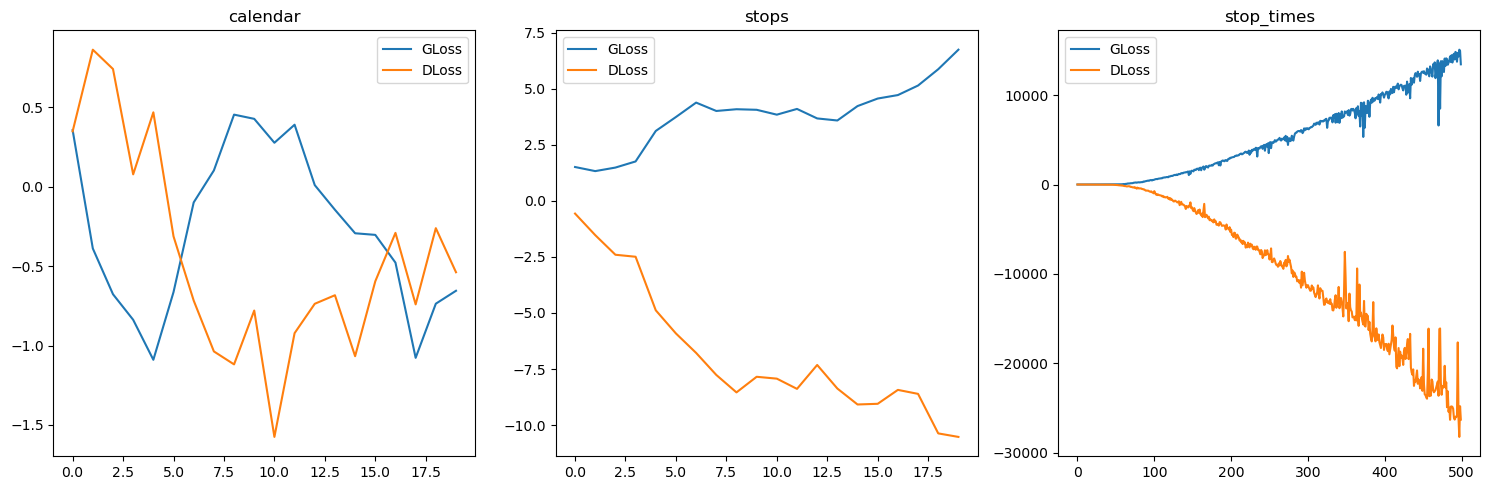

Total Time Used: 6m 23s
CPU times: total: 6min 26s
Wall time: 6min 23s


In [60]:
%%time

collection_training(processed_data_collection, modelling_metadata, training_parameter_dict)

In [61]:
training_end_time = time.time()
training_end_time = training_end_time - training_start_time
minutes, seconds = divmod(training_end_time, 60)
print(f'Total Training Time: {minutes}m {seconds}s.')

Total Training Time: 6.0m 41.626269578933716s.


In [62]:
generation_start_time = time.time()

## Set the number of rows to generate.

In [63]:
generation_dict = {k:{'nrows':len(v)} for k,v in real_data_collection.items()}

In [64]:
generation_dict

{'agency': {'nrows': 15},
 'calendar': {'nrows': 121},
 'calendar_dates': {'nrows': 674},
 'routes': {'nrows': 215},
 'stops': {'nrows': 6714},
 'stop_times': {'nrows': 966790},
 'trips': {'nrows': 32403}}

In [65]:
with open('pkl/gtfs/real_data_collection.pkl', 'wb') as f:
    pickle.dump(real_data_collection, f)

In [66]:
del real_data_collection

In [67]:
del transformed_data_collection

In [68]:
del processed_data_collection

# Synthetic Data Generation

## Define Interpolation Function

In [69]:
def adjust_unique_elements(df, min_max_range, ignore=[]):
    """
    Interpolate columns in a dataframe to have the correct minimum and maximum.
    
    Args:
        df, (dataframe):
            dataframe to be interpolated.
        min_max_range, (dict):
            dictionary containing the minimum and maximum range of each column of the dataframe.
        ignore, (list):
            a list specifying the columns to skip the interpolation. Empty by default, i.e. interpolate all columns by default.
        
    Returns:
        df_interpolated, (dataframe):
            The interpolated dataframe.
    """
    df_interpolated = df.copy()
    for col, range_ in min_max_range.items():
        if col not in ignore:
            # Interpolate the current min-max range to the min-max range stored in the min_max_range dictionary
            interpolator = interp1d([df[col].min(), df[col].max()], [range_['min'], range_['max']], kind='slinear', fill_value=(range_['min'], range_['max']))
            df_interpolated[col] = interpolator(df[col]).round()
    return df_interpolated

## Define KDE Sampling Strategy

In [70]:
def generate_kde_data(kde, n_samples, col_names, round_=False):
    """
    Generate fake categorical data by sampling the KDE fitted kernel distribution.
    col_names is to specify the column names since the output is a dataframe.
    """
    new_data = kde.sample(n_samples)
    if round_:
        new_data_df = pd.DataFrame(new_data, columns=col_names).round()
    else:
        new_data_df = pd.DataFrame(new_data, columns=col_names)
    return new_data_df

## Generate Synthetic Data

In [71]:
def generate_synth_data_collection(kde_collection, modelling_metadata, generation_dict, backtransformation_dict, formatter_collection, transform_method_dict, latent_dim=100, seed=123):
    """
    Generate synthetic data.
    
    Args:
        kde_collection, (dict):
            A dictionary containing the fitted KDE.
        modelling_metadata, (dict):
            A dictionary storing the modelling info.
        generation_dict, (dict):
            A dictionary storing generation info. Currently only contain 'nrows' fields for each table, i.e. specifying the number of rows to generate in each table.
        backtransformation_dict, (dict):
            A nested dictionary of back-transforming info.
        formatter_collection, (dict):
            A dictionary of fitted RDT transformers.
        transform_method_dict, (dict):
            A dictionary indicates whether each column was trainsformed via RDT or global ordinal encoding.
        latent_dim, (int):
            Number of latent dimension. Must match the stored generator's input dimension.
        seed, (int):
            Random seed.
    
    Returns:
        synthetic_data_collection, (dict):
            A dictionary of generated fake tables.
    """
    np.random.seed(seed)
    synthetic_data_collection = {}
    custom_objects = {'generator_loss':generator_loss}
    for df_name, content in modelling_metadata.items():
        # Check if numeric GAN-generator was trained.
        if len(backtransformation_dict[df_name]['numeric_features_col_names']) != 0:
            generator = models.load_model('models/'+df_name+'_gen.h5', custom_objects=custom_objects)
        else:
            generator = None
            
        # Obtain table info
        primary_key = content['primary_key']
        child = content['child']
        parent = content['parent']
        n_samples = generation_dict[df_name]['nrows']
        window_size = content['window_size']
        
        print(f"Generating {df_name} (size={n_samples})...")
        
        # Generate Unique primary keys if the table has primary key column
        fake_primary_key = None
        fake_selected_columns = None
        if primary_key != None:
            fake_primary_key = np.arange(n_samples)
            fake_primary_key = pd.DataFrame({primary_key:fake_primary_key})
            
        # Generate foreign key and categorical columns via KDE
        if content['selected_columns'] != []:
            kde = kde_collection[df_name]
            print(f"Generating Key and Categorical Columns...")
            kde_start_time = time.time()
            fake_selected_columns = generate_kde_data(kde, n_samples, content['selected_columns'])
            kde_elapsed_time= time.time() - kde_start_time
            minutes, seconds = divmod(kde_elapsed_time, 60)
            print("Key and Categorical Columns Generated: %dm %ds." % (minutes, seconds))
            
            # Interpolate the foreign keys and categories to the correct min-max-range.
            min_max_range = backtransformation_dict[df_name]['min_max_range']
            if parent != None:
                for parent_table, f_keys in parent.items():
                    min_max_range[f_keys] = {'min':0,'max':generation_dict[parent_table]['nrows']-1}
                fake_selected_columns = adjust_unique_elements(fake_selected_columns, min_max_range)
            else:
                fake_selected_columns = adjust_unique_elements(fake_selected_columns, min_max_range)
        
        # Form the conditional input for the numeric generator.
        # If the table has primary key column, join primary key with the foreign key and categorical columns.
        # Else, make the conditional input the foreign key and categorical columns.
        if fake_primary_key is not None:
            if fake_selected_columns is not None:
                fake_conditions = pd.concat([fake_primary_key, fake_selected_columns], axis=1)
            else:
                fake_conditions = fake_primary_key
        else:
            fake_conditions = fake_selected_columns
        
        # Rearange the order of the columns to the correct order that mateches the generator input.
        fake_conditions = fake_conditions.reindex(columns=backtransformation_dict[df_name]['conditions_col_names'])
        
        # Sort the conditions if the table is sequential.
        if content['is_sequential'] == True:
            fake_conditions = fake_conditions.sort_values(by=content['sort_order'])
        
        # Create a scaled version of the conditions
        scaled_fake_conditions = backtransformation_dict[df_name]['conditions_scaler'].transform(fake_conditions)
        
        if generator is not None:
            # Create latent noise matrix
            latent_dim = 100
            noise = np.random.normal(0, 1, size=(n_samples-window_size+1, window_size, latent_dim))
            
            print(f"Generating Numeric Columns...")
            generator_start_time=time.time()
            
            # Transform the scaled conditions to 3D (n_rows, window_size, n_cols) shape.
            sw = CustomSlidingWindow(window_size)
            scaled_fake_conditions = sw.transform(scaled_fake_conditions)
            
            # Generate scaled 3D numeric columns
            raw_fake_numeric = generator.predict([noise, scaled_fake_conditions], verbose=1)
            
            # Inverse transform the numeric columns back to 2D
            raw_fake_numeric = sw.inverse_transform(raw_fake_numeric, use_mean=True)
            
            # Unscaling the numeric columns
            fake_numeric = backtransformation_dict[df_name]['numeric_features_scaler'].inverse_transform(raw_fake_numeric)
            fake_numeric = pd.DataFrame(fake_numeric, columns=backtransformation_dict[df_name]['numeric_features_col_names'])
            
            # Concatenate the conditional columns with the numeric columns.
            fake_table = pd.concat([fake_conditions.iloc[:n_samples], fake_numeric], axis=1)
            
            # Inverse transform columns that were transformed via RDT back to the original format, or 'look'.
            fake_subset = formatter_collection[df_name].reverse_transform_subset(fake_table[transform_method_dict[df_name]['rdt']])
            fake_table = pd.concat([fake_table[transform_method_dict[df_name]['global_ordinal']], fake_subset], axis=1)
            
            generator_elapsed_time= time.time() - generator_start_time
            minutes, seconds = divmod(generator_elapsed_time, 60)
            print("Numeric Columns Generated: %dm %ds." % (minutes, seconds))
        
        else:
            # If no numeric generator was trained, i.e. there is no numeric column.
            # Make the fake table the conditional columns, i.e. primary, forein and categorical coluns.
            fake_table = fake_conditions
            fake_subset = formatter_collection[df_name].reverse_transform_subset(fake_table[transform_method_dict[df_name]['rdt']])
            fake_table = pd.concat([fake_table[transform_method_dict[df_name]['global_ordinal']], fake_subset], axis=1)
        
        # Rearange the order of the columns to the original order.
        fake_table = fake_table.reindex(columns=backtransformation_dict[df_name]['col_names'])
        synthetic_data_collection[df_name] = fake_table
        print()
    return synthetic_data_collection

In [72]:
%%time

synthetic_data_collection = generate_synth_data_collection(kde_collection, modelling_metadata, generation_dict, backtransformation_dict, formatter_collection, transform_method_dict)

Generating agency (size=15)...
Generating Key and Categorical Columns...
Key and Categorical Columns Generated: 0m 0s.

Generating calendar (size=121)...
Generating Key and Categorical Columns...
Key and Categorical Columns Generated: 0m 0s.
Generating Numeric Columns...
4/4 [==============================] - 0s 42ms/step
Numeric Columns Generated: 0m 0s.

Generating calendar_dates (size=674)...
Generating Key and Categorical Columns...
Key and Categorical Columns Generated: 0m 0s.

Generating routes (size=215)...
Generating Key and Categorical Columns...
Key and Categorical Columns Generated: 0m 0s.

Generating stops (size=6714)...
Generating Key and Categorical Columns...
Key and Categorical Columns Generated: 0m 0s.
Generating Numeric Columns...
210/210 [==============================] - 1s 2ms/step
Numeric Columns Generated: 0m 0s.

Generating stop_times (size=966790)...
Generating Key and Categorical Columns...
Key and Categorical Columns Generated: 0m 0s.
Generating Numeric Colum

## Generate/Replace Key Columns with Regular Expression

An optional step that replace the key columns which are integers right from the generate_synth_data_collection() output, to regex generated values or PIIs.

In [73]:
def replace_keys_with_regex(data_collection, sdv_metadata):
    """
    An optional step that replace the key columns which are integers right from the generate_synth_data_collection() output, to regex generated values or PIIs.
    
    Args:
        data_collection, (dict):
            A dictionary of dataframes.
        sdv_metadata, (dict):
            The dictionary form of a valid sdv.metadata.multi_table.MultiTableMetadata object.
    
    Returns:
        data_collection, (dict):
            A dictionary of dataframes with key columns globally replaced with regex generated PIIs.
    """
    # Generate a mapping from old primary keys to new ones for each table
    primary_key_mappings = {}
    for df_name, content in sdv_metadata['tables'].items():
        df = data_collection[df_name]

        # Skip tables without a primary key
        if 'primary_key' not in content:
            continue

        primary_key = content['primary_key']

        # Skip columns without regex
        if 'regex_format' not in content['columns'][primary_key]:
            continue

        regex = content['columns'][primary_key]['regex_format']

        # Generate new primary keys
        regex_primary_keys = [exrex.getone(regex) for _ in range(len(df))]

        # Check if new keys are unique. If not, regenerate.
        while len(regex_primary_keys) != len(set(regex_primary_keys)):
            regex_primary_keys = [exrex.getone(regex) for _ in range(len(df))]

        # Create mapping from old primary keys to new ones
        primary_key_mappings[df_name] = dict(zip(df[primary_key], regex_primary_keys))

        # Replace the primary keys in the original df
        df[primary_key] = regex_primary_keys

    # Update the foreign keys in each table
    for relationship in sdv_metadata['relationships']:
        parent_df_name = relationship['parent_table_name']
        child_df_name = relationship['child_table_name']
        child_foreign_key = relationship['child_foreign_key']

        # Get the mapping from old to new primary keys for the parent table
        key_mapping = primary_key_mappings.get(parent_df_name)

        # If there's no key mapping (i.e. the parent table has no primary key)
        # skip this relationship
        if key_mapping is None:
            continue

        # Replace the foreign keys in the child table
        data_collection[child_df_name][child_foreign_key] = data_collection[child_df_name][child_foreign_key].map(key_mapping)

    return data_collection

In [74]:
%%time
synthetic_data_collection = replace_keys_with_regex(synthetic_data_collection, sdv_metadata.to_dict())

CPU times: total: 4.47 s
Wall time: 4.48 s


In [75]:
generation_end_time = time.time()
generation_end_time = generation_end_time - generation_start_time
minutes, seconds = divmod(generation_end_time, 60)
print(f'Total Generation Time: {minutes}m {seconds}s.')

Total Generation Time: 1.0m 35.53868508338928s.


## (Optional) Adjust Daylight-Savings

In [76]:
synthetic_data_collection['stop_times'] = adjust_time(synthetic_data_collection['stop_times'], ['arrival_time','departure_time'])

# Save Generated Data and Metadata

In [77]:
with open('pkl/gtfs/synthetic_data_full_epoch.pkl', 'wb') as f:
    pickle.dump(synthetic_data_collection, f)

In [78]:
with open('pkl/gtfs/sdv_metadata.pkl', 'wb') as f:
    pickle.dump(sdv_metadata, f)